# Supply Chain Distribution Network Design via Unserpervised Machine Learning

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from collections import Counter
import random
from sklearn import metrics

### Input data file containing customer location coordinates
Located within root folder of repo "customer_demand.csv"

In [2]:
customer_locs = pd.read_csv(r'C:\Misc\Interview\Data_Mining\customer_locations.csv')

Quick view of customer data

In [3]:
customer_locs.head()

,Latitude,Longitude
0,29.654018,-82.331194
1,37.644394,-77.408579
2,42.298309,-83.277322
3,42.929592,-78.734828
4,43.101855,-75.235125


### Data Cleansing & Prep

In [4]:
#Check record counts for each column to ensure consistency

customer_locs.count()

Latitude     913
Longitude    913
dtype: int64

In [5]:
#Drop rows with na value

customer_locs = customer_locs.dropna()

In [6]:
#Check for duplicate customer coordinates, add duplicate indicator column and re create data frame without duplicate records

customer_locs["is_dup"]=customer_locs.duplicated()

customer_locs = customer_locs[customer_locs['is_dup'] == False]

In [7]:
#Quick View of data frame

customer_locs.head()

,Latitude,Longitude,is_dup
0,29.654018,-82.331194,False
1,37.644394,-77.408579,False
2,42.298309,-83.277322,False
3,42.929592,-78.734828,False
4,43.101855,-75.235125,False


In [8]:
#Verify new count

customer_locs.count()

Latitude     882
Longitude    882
is_dup       882
dtype: int64

In [9]:
#Remove duplicate identifier column

customer_locs = customer_locs.drop('is_dup', axis = 1)

customer_locs.head()

,Latitude,Longitude
0,29.654018,-82.331194
1,37.644394,-77.408579
2,42.298309,-83.277322
3,42.929592,-78.734828
4,43.101855,-75.235125


In [10]:
#Eliminate customer locations outside of North America

customer_locs = customer_locs[customer_locs.Latitude > 25]

customer_locs = customer_locs[customer_locs.Longitude < -60]


customer_locs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 849 entries, 0 to 912
Data columns (total 2 columns):
Latitude     849 non-null float64
Longitude    849 non-null float64
dtypes: float64(2)
memory usage: 19.9 KB


In [11]:
#Re index data frame after removing records

customer_locs = customer_locs.reset_index(drop=True)

In [12]:
#Create customer names

i=0

for i in range(0,len(customer_locs)):
    customer_locs.loc[i,'Name'] = 'C_' + str(i)
    


customer_locs = customer_locs.dropna()

In [13]:
#Quick view of modified data frame

customer_locs.head()

,Latitude,Longitude,Name
0,29.654018,-82.331194,C_0
1,37.644394,-77.408579,C_1
2,42.298309,-83.277322,C_2
3,42.929592,-78.734828,C_3
4,43.101855,-75.235125,C_4


In [14]:
#Add randomly generated demand records

x=0

for x in range(0,len(customer_locs)):
    customer_locs.loc[x,'Demand'] = random.randint(1,100)
    


customer_locs = customer_locs.dropna()


In [15]:
#Check record counts
customer_locs.count()

Latitude     849
Longitude    849
Name         849
Demand       849
dtype: int64

### Isolate and create data set for modeling

In [16]:
#Create arrays for individual columns

X1 = pd.Series(customer_locs.Latitude)
X2 = pd.Series(customer_locs.Longitude)
X3 = pd.Series(customer_locs.Name)
X4 = pd.Series(customer_locs.Demand)

### Weighting of customer location based on quantity of demand 
i.e. A customer with demand quantity of 10 would repeat it's location 10 times, a demand quantity of 100 would be repeated 100 times, etc.
The only modeling features left are the 2 dimensional coordinates replicated to represent "demand weighting" in KMeans

In [17]:
#Repeat coordinates X times per total demand quantity for observation weighting in Kmeans
w_lat = X1.repeat(round(customer_locs.Demand))
w_lon = X2.repeat(round(customer_locs.Demand))

# #Create final dataframe for modeling
customers_wgtd = pd.concat([w_lat, w_lon], axis=1)

### Define number of nodes (distribution centers) for model review 
i.e. 6 hubs for central density determination

In [18]:
#Set n to number of nodes(hubs)
n = 6

### *Optional - Use elbow method to determine "optimal" number of distribution centers/clusters

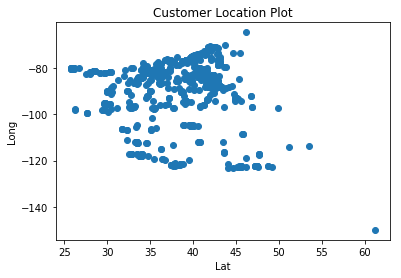

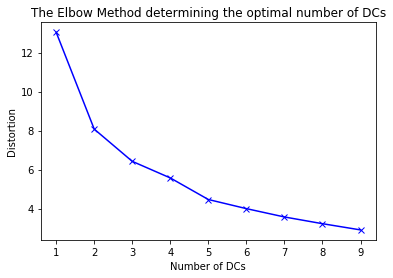

In [19]:
#Sample plot of customer location distribution

plt.plot()
plt.xlabel('Lat')
plt.ylabel('Long')
plt.title('Customer Location Plot')
plt.scatter(X1, X2)
plt.show()


#Run K-means with 1-10 clusters and record errors

Y = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(customers_wgtd)
    kmeanModel.fit(customers_wgtd)
    Y.append(sum(np.min(cdist(customers_wgtd, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / customers_wgtd.shape[0])

# Plot the K-means distortion by number of clusters/DCs
plt.plot(K, Y, 'bx-')
plt.xlabel('Number of DCs')
plt.ylabel('Distortion')
plt.title('The Elbow Method determining the optimal number of DCs')
plt.show()


Based upon the above elbow plot anywhere from 4-6 DCs would capture a reasonable amount of the model error (think 80/20 rule).

### Execute modeling on data

In [20]:
#Define number of clusters and construct estimator pipeline
kmeans1 = KMeans(n_clusters=n)

pipeline1 = make_pipeline(kmeans1)

#Fit pipeline to sample data
pipeline1.fit(customers_wgtd)

Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [21]:
#Add labels to pipeline
Labels1 = pipeline1.predict(customers_wgtd)

#Take n cluster centers based on model input and create cluster and label dataframe

centers = pd.DataFrame(kmeans1.cluster_centers_)

df2 = pd.DataFrame({'Name': customer_locs.Name, 'Latitude': customers_wgtd.Latitude,'Longitude': customers_wgtd.Longitude, 'Cluster': Labels1} )

### Create plot of clusters and coordinate assignment

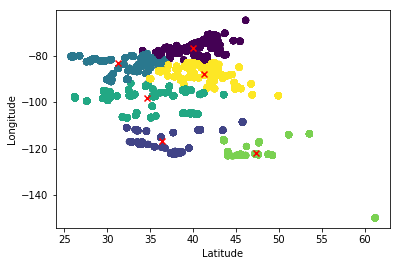

           0           1
0  40.025145  -76.854304
1  36.359697 -116.569174
2  31.193429  -83.210042
3  34.659794  -98.380416
4  47.385737 -122.081588
5  41.246281  -87.719832


In [22]:
#Create a basic scatter plot for review of DC clusters and assignments

plt.scatter(df2.Latitude,df2.Longitude, c= df2.Cluster )
plt.scatter(centers[0], centers[1], marker="x", color='r')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()


#Output DC cluster coordinates
print(centers)

In [24]:
#Create interactive map visualization color coding cluster values and applying centroids/DC locations

this_map = folium.Map(location=[41.85,-87.69], zoom_start = 8)

#Loop through coordinates and apply distinct color per cluster/DC label 

for index, row in df2.iterrows():
    if row['Cluster'] == 0:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'red').add_to(this_map)
        
    if row['Cluster'] == 1:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'orange').add_to(this_map)
        
    if row['Cluster'] == 2:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'yellow').add_to(this_map)
        
    if row['Cluster'] == 3:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'green').add_to(this_map)
        
    if row['Cluster'] == 4:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'blue').add_to(this_map)
        
    if row['Cluster'] == 5:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'indigo').add_to(this_map)
        
    if row['Cluster'] == 6:
        folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], radius = 3, color = 'violet').add_to(this_map)

#Plot centroids for each DC/cluster
for index, row in centers.iterrows():
    folium.Marker(location = [row[0], row[1]], radius = 10).add_to(this_map)  
    
#Set map zoom position
this_map.fit_bounds(this_map.get_bounds())

#Save the map to an HTML file
this_map.save('DC_customer_map.html')


Open .html map to view a map of all customer locations and associated clusters with color coding assignment